# Calculating corrected NDVI using the methodology of Petach et al 2014
http://harvardforest.fas.harvard.edu/sites/harvardforest.fas.harvard.edu/files/publications/pdfs/Petach_AgriForestMeteor_2014.pdf

In [1]:
import os
import math

import matplotlib as mpl
import matplotlib.pyplot as plt

import skimage

import numpy as np
import seaborn as sns

In [2]:
import sys
sys.path.append(r"..")

import pyphenocam

### Calculate NDVI at the 'harvardbarn' site

In [3]:
sites = pyphenocam.dataaccess.get_sites_df()
sites.head(4)

site        lat         lon  elevation  \
0          acadia  44.376944  -68.260833      158.0   
1   aguatibiaeast  33.622000 -116.867000     1086.0   
2  aguatibianorth  33.602220 -117.343680     1090.0   
3        ahwahnee  37.746700 -119.581600     1199.0   

                                         description  
0  Acadia National Park, McFarland Hill, near Bar...  
1                  Agua Tibia Wilderness, California  
2                  Agua Tibia Wilderness, California  
3  Ahwahnee Meadow, Yosemite National Park, Calif...

In [4]:
harvard = pyphenocam.dataaccess.get_site('harvardbarn')

which_img = 201

C:\Anaconda3\envs\pyphenocam\lib\site-packages\urllib3\connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


C:\Anaconda3\envs\pyphenocam\lib\site-packages\urllib3\connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\Anaconda3\envs\pyphenocam\lib\site-packages\skimage\exposure\exposure.py:297: RuntimeWarning: invalid value encountered in true_divide
  image = (image - imin) / float(imax - imin)
..\pyphenocam\headerextraction.py:36: RuntimeWarning: invalid value encountered in less
  _skimage.exposure.rescale_intensity(1 - sobel_hsv(l3_range)), axis=2) < 2
..\pyphenocam\headerextraction.py:38: RuntimeWarning: invalid value encountered in less
  _skimage.exposure.rescale_intensity(1 - sobel_hsv(l4_range)), axis=2) < 2


Extracted exposure:  300.0


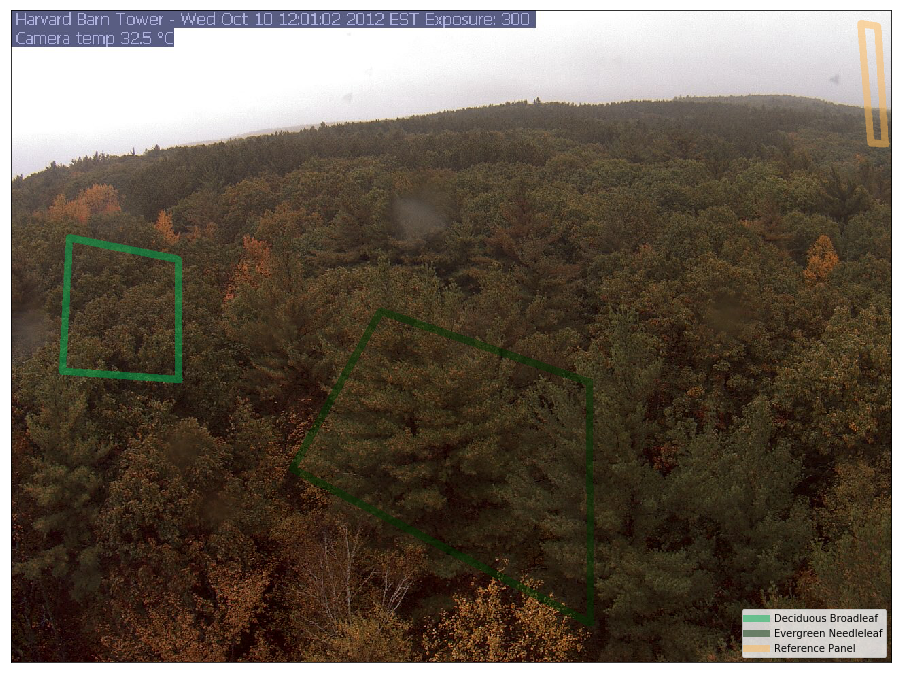

In [5]:
%matplotlib inline
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111)
local_fname = harvard.get_local_image_fname(harvard.midday_fnames[which_img])
# print local_fname
ax.imshow(harvard.get_local_image(harvard.midday_fnames[which_img]))

pyphenocam.plotting.add_rois(ax, harvard, vistype='line', lw=7, alpha=0.5)

pyphenocam.plotting.format_photo_axes(ax)
plt.legend(loc=4)

exposure = float(pyphenocam.headerextraction.get_exposure(local_fname))
print("Extracted exposure: ", exposure)

138.0


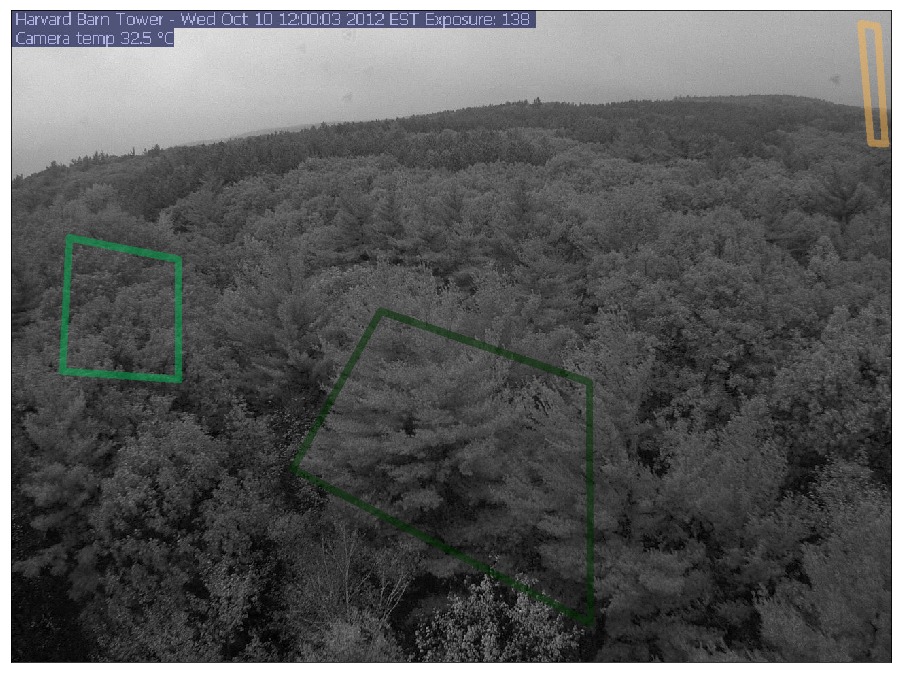

In [10]:
%matplotlib inline
local_fname_ir = harvard.get_local_image_fname(harvard.midday_fnames[which_img], IR=True)

fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111)

ax.imshow(harvard.get_local_image(harvard.midday_fnames[which_img], IR=True))

roi = harvard.get_roi(masked=True)

pyphenocam.plotting.add_rois(ax, harvard, vistype='line', lw=7, alpha=0.5)

pyphenocam.plotting.format_photo_axes(ax)
nir_exposure = float(pyphenocam.headerextraction.get_exposure(local_fname_ir))
print(nir_exposure)

In [11]:
r, g, b = [np.squeeze(a) for a in np.split(skimage.io.imread(local_fname), 3, axis=2)]
z = skimage.io.imread(local_fname_ir)[:,:,0].astype(float)

#equation 4b
y = 0.3*r + 0.59*g + 0.11*b

#equation 5a
z_prime =  z/(math.sqrt(nir_exposure))
#equation 5b
r_prime = r/(math.sqrt(exposure))
#equation 5c
y_prime = y/(math.sqrt(exposure))
#equation 5d
x_prime = z_prime - y_prime

#equation 6
ndvi_c = ((x_prime - r_prime) / (x_prime + r_prime))

#equation 7
a = 0.53
b_ = 0.83
ndvi_c2 = (a * ndvi_c) + b_


0 $R^\prime_{dn}$
1 $Z^\prime_{dn}$
2 $X^\prime_{dn}$
3 $Y^\prime_{dn}$
4 $Camera NDVI$
5 $Radiometer NDVI$


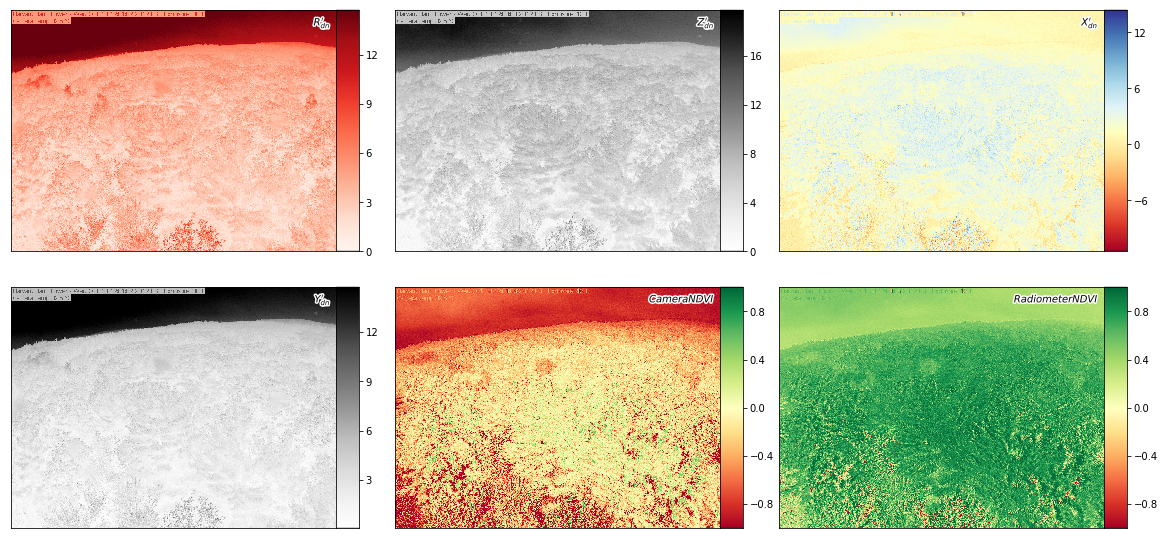

In [17]:
fig = plt.figure(figsize=(20, 10))

from mpl_toolkits.axes_grid1 import ImageGrid
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2,3),  # creates 2x2 grid of axes
                 axes_pad=0.5,  # pad between axes in inch.
                 cbar_location="right",
                cbar_mode="each",
                cbar_size="7%",
                cbar_pad="0%", 
                share_all=True)

for i, c in enumerate([(r_prime, '$R^\prime_{dn}$', mpl.cm.Reds),
                       (z_prime, '$Z^\prime_{dn}$', mpl.cm.Greys),
                       (x_prime, '$X^\prime_{dn}$', mpl.cm.RdYlBu),
                       (y_prime, '$Y^\prime_{dn}$', mpl.cm.Greys),
                       (ndvi_c, '$Camera NDVI$', mpl.cm.RdYlGn),
                       (ndvi_c2, '$Radiometer NDVI$', mpl.cm.RdYlGn),]):
    
    c, title, cm = c
    print(i, title)
#     print c[s]
    
    if 'NDVI' in title:
        im = grid[i].imshow(c, cmap=cm, interpolation='none', vmin=-1, vmax=1.)
    else:
        im = grid[i].imshow(c, cmap=cm, interpolation='none')
        
    grid[i].cax.colorbar(im)
    
    grid[i].get_xaxis().set_visible(False)
    grid[i].get_yaxis().set_visible(False)
    
    t = pyphenocam.plotting.add_inner_title(grid[i], title, loc=1)


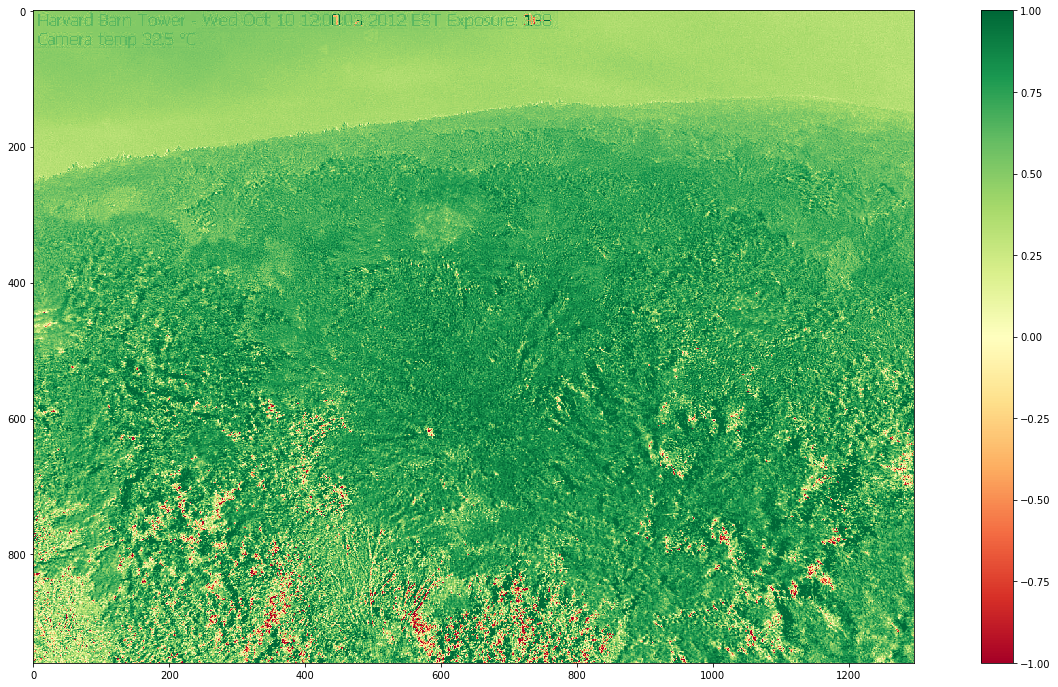

In [18]:
fig = plt.figure(figsize=(24, 12))
plt.imshow(ndvi_c2, vmin=-1, vmax=1., cmap=mpl.cm.RdYlGn)
plt.colorbar()

### and a histogram of those adjusted NDCI data

In [20]:
flat_ndvi = ndvi_c.flatten()
#but this data has a few nans, let's remove them from the histogram
print("number of NaN values = {}".format(np.isnan(flat_ndvi).sum()))
flat_ndvi_nonan = flat_ndvi[~np.isnan(flat_ndvi)]
#but this data has a few number below or above the expecteded NDVI range
#let's remove them from the histogram
print ("number of values > 1 = {}".format((flat_ndvi_nonan > 1.0).sum()))
print ("number of values > 1 = {}".format((flat_ndvi_nonan < -1.0).sum()))
ndvi_good = flat_ndvi_nonan[np.where(np.logical_and(flat_ndvi_nonan<=1.00, flat_ndvi_nonan>=-1.0))]


flat_ndvic = ndvi_c2.flatten()
#but this data has a few nans, let's remove them from the histogram
print( "number of NaN values = {}".format(np.isnan(flat_ndvic).sum()))
flat_ndvic_nonan = flat_ndvic[~np.isnan(flat_ndvic)]
#but this data has a few number below or above the expecteded NDVI range
#let's remove them from the histogram
print( "number of values > 1 = {}".format((flat_ndvic_nonan > 1.0).sum()))
print( "number of values > 1 = {}".format((flat_ndvic_nonan < -1.0).sum()))
ndvic_good = flat_ndvic_nonan[np.where(np.logical_and(flat_ndvic_nonan<=1.00, flat_ndvic_nonan>=-1.0))]


number of NaN values = 0
number of values > 1 = 0
number of values > 1 = 61239
number of NaN values = 0
number of values > 1 = 39519
number of values > 1 = 3233


C:\Anaconda3\envs\pyphenocam\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


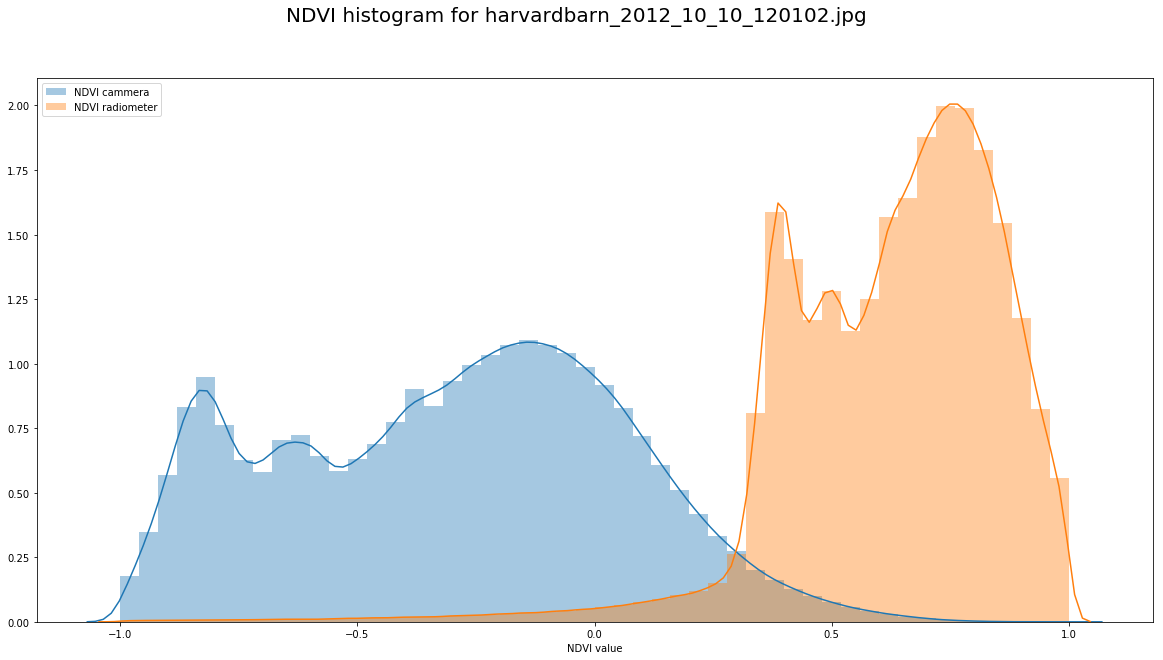

In [21]:
fig = plt.figure(figsize=(20,10))

ax = sns.distplot(ndvi_good, label='NDVI cammera')
ax = sns.distplot(ndvic_good, label='NDVI radiometer')

title = "NDVI histogram for {}".format(os.path.split(local_fname)[1])
fig.suptitle(title, fontsize=20)
ax.set_xlabel('NDVI value')

plt.legend(loc='upper left')
